# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.389050,True,4.047824
1,0.824519,False,0.971257
2,0.372476,True,3.453247
3,1.757448,False,-0.456451
4,0.465103,True,3.647494
...,...,...,...
995,0.490090,True,4.473940
996,-1.011021,False,0.127955
997,0.554732,False,-0.144291
998,2.998804,False,-0.079245


<AxesSubplot: xlabel='v0'>

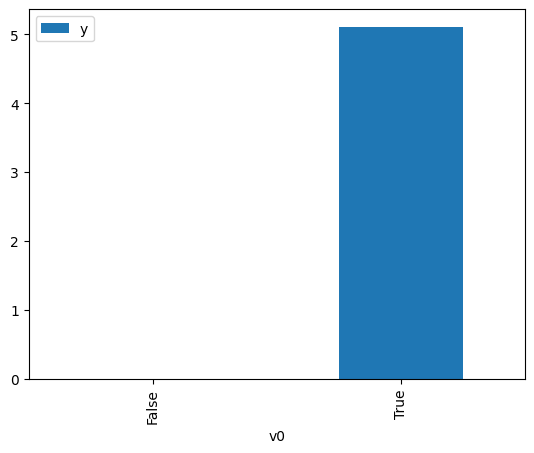

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

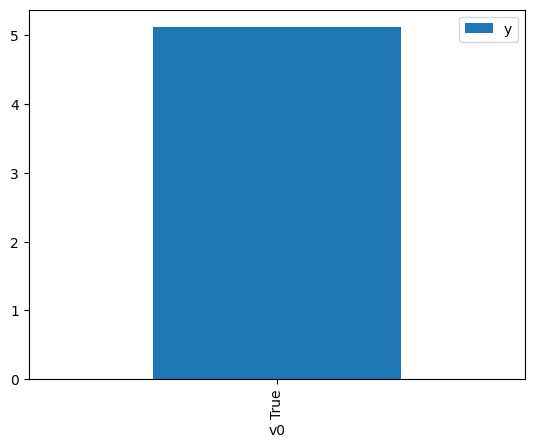

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.472198,False,-1.481135,0.518445,1.928844
1,-1.469897,False,-0.837376,0.562333,1.778306
2,-0.218731,False,1.390149,0.507223,1.971521
3,1.203872,False,0.637244,0.444422,2.250113
4,-1.869815,False,-0.978760,0.579693,1.725051
...,...,...,...,...,...
995,-0.081905,False,0.369544,0.501161,1.995367
996,0.582789,False,1.262328,0.471740,2.119811
997,1.556509,False,0.245223,0.429049,2.330735
998,1.350960,False,0.524023,0.437995,2.283130


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.650402,True,5.682519,0.531245,1.882371
1,1.817854,True,5.937038,0.582258,1.717452
2,0.337701,True,4.473655,0.517424,1.932652
3,0.738157,True,5.271768,0.535116,1.868754
4,-0.218778,True,5.414599,0.492775,2.029323
...,...,...,...,...,...
995,-0.870939,True,5.818343,0.463942,2.155442
996,0.367271,True,4.420943,0.518732,1.927777
997,0.431721,True,6.548701,0.521583,1.917240
998,2.400081,True,5.736191,0.607124,1.647111


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              6422.
Date:                Tue, 24 Jan 2023   Prob (F-statistic):                        0.00
Time:                        21:11:55   Log-Likelihood:                         -1449.5
No. Observations:                1000   AIC:                                      2903.
Df Residuals:                     998   BIC:                                      2913.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3001      0.033      9.107      0.000       0.235       0.365
x2             5.1089      0.046    110.295      0.000       5.018       5.200
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.367
Skew:                           0.070   Prob(JB):                        0.505
Kurtosis:                       3.116   Cond. No.                         1.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""